In [1]:
!pip install nltk
!pip install textblob
!pip install wordcloud

In [2]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 1. Text Preprocessing

In [3]:
df = pd.read_csv("datasets/amazon_reviews.csv")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


## Normalizing Case Folding

* Completing the uppercase and lowercase conversion to a certain standard

In [4]:
df['reviewText'] = df['reviewText'].str.lower()

In [5]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",no issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. i should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",this think has worked out great.had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","bought it with retail packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4910,A2LBMKXRM5H2W9,B007WTAJTO,"ZM ""J""","[0, 0]",i bought this sandisk 16gb class 10 to use wit...,1.00,Do not waste your money.,1374537600,2013-07-23,503,0,0
4911,ALGDLRUI1ZPCS,B007WTAJTO,Zo,"[0, 0]",used this for extending the capabilities of my...,5.00,Great item!,1377129600,2013-08-22,473,0,0
4912,A2MR1NI0ENW2AD,B007WTAJTO,Z S Liske,"[0, 0]",great card that is very fast and reliable. it ...,5.00,Fast and reliable memory card,1396224000,2014-03-31,252,0,0
4913,A37E6P3DSO9QJD,B007WTAJTO,Z Taylor,"[0, 0]",good amount of space for the stuff i want to d...,5.00,Great little card,1379289600,2013-09-16,448,0,0


* Variables/situations we would like to exclude from the work so we delete them from the text as they are considered to have no meaning:
    * Punctuation marks
    * Numbers without measured value
    * Stop words (for, is, that)
    * Rare words
    

**Regular Expression:** A special structure used to complete, capture and work on a certain pattern in textual expressions.

### Punctluation Removal

In [6]:
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '')

In [7]:
df['reviewText']

0                                              no issues.
1       purchased this for my device, it worked as adv...
2       it works as expected. i should have sprung for...
3       this think has worked out great.had a diff. br...
4       bought it with retail packaging, arrived legit...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable. it ...
4913    good amount of space for the stuff i want to d...
4914    i've heard bad things about this 64gb micro sd...
Name: reviewText, Length: 4915, dtype: object

### Numbers Removal

In [8]:
df['reviewText'] = df['reviewText'].str.replace('\d', '')

In [9]:
df['reviewText']

0                                              no issues.
1       purchased this for my device, it worked as adv...
2       it works as expected. i should have sprung for...
3       this think has worked out great.had a diff. br...
4       bought it with retail packaging, arrived legit...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable. it ...
4913    good amount of space for the stuff i want to d...
4914    i've heard bad things about this 64gb micro sd...
Name: reviewText, Length: 4915, dtype: object

### Stop words

In [10]:
import nltk

nltk.download('stopwords')
sw = stopwords.words('english')

df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

df['reviewText']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tokel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0                                                 issues.
1       purchased device, worked advertised. never muc...
2       works expected. sprung higher capacity. think ...
3       think worked great.had diff. bran 64gb card we...
4       bought retail packaging, arrived legit, orange...
                              ...                        
4910    bought sandisk 16gb class 10 use htc inspire, ...
4911    used extending capabilities samsung galaxy not...
4912    great card fast reliable. comes optional adapt...
4913    good amount space stuff want do, fits gopro. say?
4914    i've heard bad things 64gb micro sd card crapp...
Name: reviewText, Length: 4915, dtype: object

### Rare words

In [11]:
temp_df = pd.Series(' '.join(df['reviewText']).split()).value_counts()

temp_df

card                      3475
works                     1468
memory                    1182
sd                        1131
phone                     1113
                          ... 
waaaaaaay                    1
s3/ip4s/ip5!                 1
11-28-12*********after       1
total...                     1
steal!would                  1
Name: count, Length: 16998, dtype: int64

In [12]:
# save the words that are used less than 1 time in the dataset
drops = temp_df[temp_df <= 1]

drops

fine).                    1
cameras/laptop            1
invented                  1
ways,                     1
ram;                      1
                         ..
waaaaaaay                 1
s3/ip4s/ip5!              1
11-28-12*********after    1
total...                  1
steal!would               1
Name: count, Length: 10805, dtype: int64

In [13]:
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

df['reviewText']

0                                                 issues.
1       purchased device, worked advertised. never muc...
2       works expected. higher capacity. think made bi...
3       think worked 64gb card went south 3 one held p...
4       bought retail packaging, arrived legit, versio...
                              ...                        
4910    bought sandisk 16gb class 10 use htc 3 months,...
4911    used capabilities samsung galaxy note 10. grea...
4912    great card fast reliable. comes optional adapt...
4913    good amount space stuff want do, fits gopro. say?
4914    i've heard bad things 64gb micro sd card crapp...
Name: reviewText, Length: 4915, dtype: object

## Tokenization

Tokenization in the context of natural language processing (NLP) refers to the process of breaking down text into smaller units, typically words or sentences. It’s a crucial first step in many NLP tasks, such as text analysis, machine translation, and sentiment analysis.

Here's what tokenization means in different contexts:

1. **Word Tokenization**:
   - **Definition**: Splitting a sentence or text into individual words.
   - **Example**: "The quick brown fox jumps over the lazy dog."
     - After tokenization: `["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"]`

2. **Sentence Tokenization**:
   - **Definition**: Splitting text into individual sentences.
   - **Example**: "Hello world. This is ChatGPT."
     - After tokenization: `["Hello world.", "This is ChatGPT."]`

3. **Subword Tokenization**:
   - **Definition**: Splitting words into smaller units, especially useful for handling unknown words or languages with rich morphology.
   - **Example**: The word "tokenization" might be broken down into `["token", "ization"]`.

### Sorting in Tokenization
If by "sort," you mean arranging the tokens in a specific order (e.g., alphabetical order), that’s different from the standard tokenization process. Sorting tokens can be done after tokenization for tasks like creating a vocabulary list, indexing, or searching.

- **Example**: Alphabetical sorting of tokens
  - Tokens: `["jumps", "brown", "dog", "quick"]`
  - After sorting: `["brown", "dog", "jumps", "quick"]`

### Summary
- **Tokenization**: Breaking text into smaller pieces like words or sentences.
- **Sorting**: Arranging those tokens in a specific order, typically done after tokenization if needed. 

Let me know if you were referring to a specific type of sorting or another aspect of tokenization!

In [14]:
import nltk
from textblob import TextBlob

# Download the necessary NLTK corpora
nltk.download('punkt', force=True)
nltk.download('averaged_perceptron_tagger')

# Now apply the TextBlob processing
df['reviewText'].apply(lambda x: TextBlob(x).words).head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tokel\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tokel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


MissingCorpusError: 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.


## Lemmatization

Separating words into their roots. For example, -s, -ing, etc. in words. remove word suffixes.

In [15]:
nltk.download('wordnet')

df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tokel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
df['reviewText']

0                                                 issues.
1       purchased device, worked advertised. never muc...
2       work expected. higher capacity. think made bit...
3       think worked 64gb card went south 3 one held p...
4       bought retail packaging, arrived legit, versio...
                              ...                        
4910    bought sandisk 16gb class 10 use htc 3 months,...
4911    used capability samsung galaxy note 10. greatl...
4912    great card fast reliable. come optional adapte...
4913     good amount space stuff want do, fit gopro. say?
4914    i've heard bad thing 64gb micro sd card crappi...
Name: reviewText, Length: 4915, dtype: object

# 2. Text Visualization

## Calculation of Term Frequencies

In [17]:
tf = df["reviewText"].fillna('').apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()


In [18]:
tf.columns = ['words', 'tf']

In [19]:
tf

,words,tf
0,issues.,115.00
1,purchased,331.00
2,"device,",38.00
3,worked,436.00
4,advertised.,49.00
...,...,...
5860,archive,2.00
5861,pureview,3.00
5862,laptop/tablet.,2.00
5863,sandisk:sequential,2.00


In [20]:
tf.sort_values("tf", ascending=False)

,words,tf
26,card,4130.00
15,work,1879.00
7,phone,1220.00
109,memory,1192.00
65,sd,1133.00
...,...,...
2591,"mostly,",2.00
4479,alway,2.00
2597,complaints!,2.00
5864,4.9,2.00


## Bar Plot

In [21]:
tf[tf["tf"] > 500] # words that are used more than 500 times in the dataset

,words,tf
7,phone,1220.00
15,work,1879.00
26,card,4130.00
37,one,947.00
43,bought,821.00
48,get,565.00
49,price,580.00
60,like,507.00
65,sd,1133.00
73,sandisk,1104.00


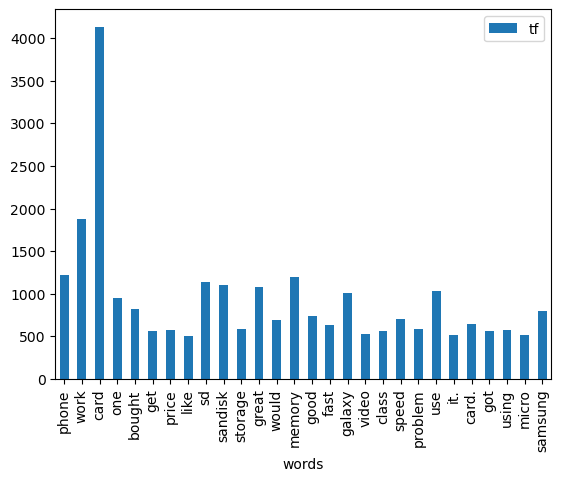

In [22]:
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

## Word Cloud

A word cloud is a visual display of text where the size of each word reflects its frequency or importance in the text. More frequent words appear larger, helping to quickly identify key themes or topics.

In [23]:
text = " ".join(i for i in df.reviewText)

In [24]:
text

'issues. purchased device, worked advertised. never much phone memory, since download lot stuff brainer me. work expected. higher capacity. think made bit earlier paint look clean think worked 64gb card went south 3 one held pretty well since s3, update month zero since transferred s3 note2. card reliable bought retail packaging, arrived legit, version asian like picture shows. arrived quickly, bought 32 16 retail packaging htc one lg card working probably best price get nice sd card mini storage. anything else supposed to. purchased add additional storage microsoft surface pro tablet come 64 128 gb. supposed sandisk long standing reputation speaks itself. phone never skip beat. file transfer speedy corruption issue memory issue would expect sandisk brand. great card own. precious file slightly cheaper piece lose everything spending extra couple buck trusted product go good hard believe affordable digital 32 gb device one quarter postage would less generation picked portable music want

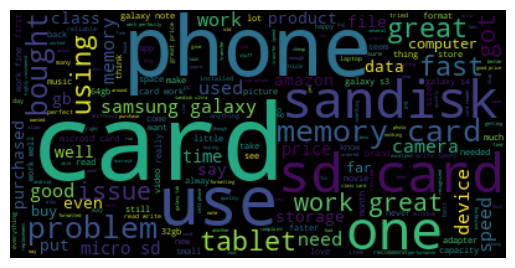

In [25]:
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

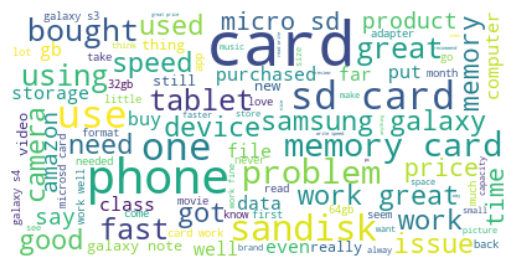

In [26]:
wordcloud = WordCloud(max_font_size=50, 
                      max_words=100, 
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")

## Wordcloud by Templates

The process of combining word cloud and templates

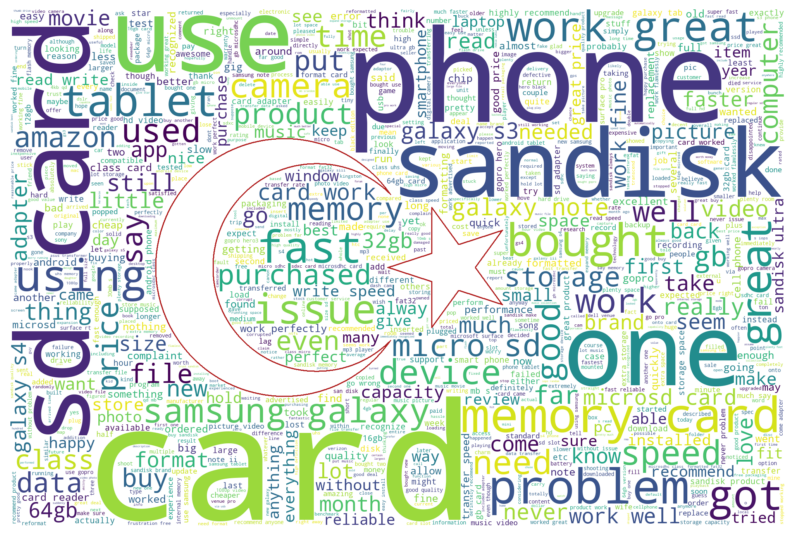

In [40]:
tr_mask = np.array(Image.open("images/turkish_flag.png"))

wc = WordCloud(background_color="white", 
               max_words=1000, mask=tr_mask, 
               contour_width=3, 
               contour_color='firebrick')
wc.generate(text)
plt.figure(figsize=[10, 10])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off') 
plt.show()

wordcloud.to_file("turkish_flag_wordcloud.png")

# 3. Sentiment Analysis

In [41]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","purchased device, worked advertised. never muc...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected. higher capacity. think made bit...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked 64gb card went south 3 one held p...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","bought retail packaging, arrived legit, versio...",5.00,best deal around,1373673600,2013-07-13,513,0,0


In [42]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tokel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [43]:
sia = SentimentIntensityAnalyzer()

In [44]:
sia.polarity_scores("The film was awesome")

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

polarity_scores shows dome scores:

neg - negative

neu - neutral

pos - positive

compound -most important one

---

polarity scores, i.e. emotion scores, lie between -1 and 1
if compound is bigger than 0, It means the sentence is positive
if compound is smaller than 0, It means the sentence is negative

In [45]:
sia.polarity_scores("I liked this music but it is not good as the other one")

{'neg': 0.207, 'neu': 0.666, 'pos': 0.127, 'compound': -0.298}

In [46]:
# apply the sentiment analysis to the reviewText column
df["polarity_score"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])

df["polarity_score"]

0       0.00
1       0.00
2       0.40
3       0.65
4       0.86
        ... 
4910   -0.20
4911    0.18
4912    0.85
4913    0.69
4914    0.53
Name: polarity_score, Length: 4915, dtype: float64

In [48]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","purchased device, worked advertised. never muc...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected. higher capacity. think made bit...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked 64gb card went south 3 one held p...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.65
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","bought retail packaging, arrived legit, versio...",5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86


# 4. Feature Engineering

We are labeling the texts

In [51]:
df["reviewText"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    neg
1    neg
2    pos
3    pos
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: reviewText, dtype: object

In [52]:
df["sentiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [53]:
df["sentiment_label"].value_counts()

sentiment_label
pos    3933
neg     982
Name: count, dtype: int64

In [54]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score,sentiment_label
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00,neg
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","purchased device, worked advertised. never muc...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00,neg
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected. higher capacity. think made bit...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40,pos
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked 64gb card went south 3 one held p...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.65,pos
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","bought retail packaging, arrived legit, versio...",5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86,pos


In [55]:
df.groupby("sentiment_label")["overall"].mean()

sentiment_label
neg   4.11
pos   4.71
Name: overall, dtype: float64

In [56]:
# Label Encoding
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])
df["sentiment_label"].head()

0    0
1    0
2    1
3    1
4    1
Name: sentiment_label, dtype: int32

In [57]:
# identify dependent and independent variables
X = df["reviewText"]
y = df["sentiment_label"]

Texts in X are not measurable. Let's bring them to a measurable format:

## How to bring datas to measurable format?

We can vectorize the data to models understand.

Vectorization Methods

* Count Vectors: frequency representations
* TF-IDF Vectors: normalized frequency representations
* Word Embeddings (Word2Vec, GloVe, BERT vs.): 

Numerical Representation Methods:

* words: numerical presentation of words
* characters: numerical presentation of characters
* ngram: N-grams show combinations of words used together. And they are used for feature extracting

### Count Vectorizer

![image.png](images/count-vectorizer.png)

In [69]:
# import the necessary libraries
from sklearn.feature_extraction.text import CountVectorizer

In [58]:
# add a sample text to the corpus
corpus = ['This is the first document.',
            'This document is the second document.',
            'And this is the third one.',
            'Is this the first document?']


#### Count Vectorizer with word frequency:

if **the words of the vectorizer words array** are in the corpus texts, they will shown as 1 in **the word frequency matrix**.

In [59]:
vectorizer = CountVectorizer()
X_c = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out() # words

array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], dtype=object)

In [60]:
X_c.toarray() # word frequency matrix

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

#### Count Vectorizer with n-gram frequency:

if **the n-phrases of the vectorizer n-gram array** are in the corpus texts, they will shown as 1 in **the n-gram frequency matrix**.

In [61]:
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X_n = vectorizer2.fit_transform(corpus)
vectorizer2.get_feature_names_out() # 2-gram

array(['and this', 'document is', 'first document', 'is the', 'is this',
       'second document', 'the first', 'the second', 'the third',
       'third one', 'this document', 'this is', 'this the'], dtype=object)

In [62]:
X_n.toarray() # 2-gram frequency matrix

array([[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]], dtype=int64)

## Let's Apply CountVectorizer with word frequency methods to independent variables (X)

In [63]:
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)
vectorizer.get_feature_names_out()[10:15] # words

array(['1080p', '10gb', '10mb', '11', '119'], dtype=object)

In [64]:
X_count.toarray() # word frequency matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### TF-IDF (Term Frequency - Inverse Document Frequency)

TF-IDF: A method of creating a normalized, standardized word vector to eliminate some biases that the Count Vector method may introduce.

Step 1: Calculate **Count Vectorizer**

Step 2: Calculate TF-IDF Term Frequency
    - frequency of the term of t in the doc / total counts of term in the doc

Step 3: Calculate IDF-Inverse Document Frequency
    - 1 + loge((total counts of the doc + 1) / (counts of the doc with the term of t + 1))

Step 4: Calculate TF * IDF

Step 5: Perform L2 normalization
    - Find the square root of the sum of squares of the rows
    - Divide all cells in the relevant row by the value you found

![image.png](images/TF-IDF.png)

In [70]:
# import the necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer

#### TF-IDF Vectorizer with word frequency:

In [78]:
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

#### TF-IDF Vectorizer with n-gram frequency:

In [79]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)

# 5. Sentiment Modeling

 1. Text Preprocessing
 2. Text Visualization
 3. Sentiment Analysis
 4. Feature Engineering
 5. Sentiment Modeling

## Logistic Regression

In [77]:
# fit the model
log_model = LogisticRegression().fit(X_tf_idf_word, y) 

# 5-fold cross validation score
cross_val_score(log_model, X_tf_idf_word, y, scoring="accuracy", cv=5).mean() 

0.8288911495422177

* Used Tf-idf Vectorizer feature extraction method with Logistic Regression model and calculated their cross validation score

In [80]:
# predict the sentiment of a new review with the model
new_review = pd.Series("this product is great")
new_review = TfidfVectorizer().fit(X).transform(new_review)

log_model.predict(new_review)

array([1])

In [85]:
# get a random review from the dataset
random_review = pd.Series(df["reviewText"].sample(1).values) 
print(random_review)

# predict the sentiment of the random review
random_review = TfidfVectorizer().fit(X).transform(random_review)
log_model.predict(random_review)

0    samsung give ability install apps sd card gala...
dtype: object


array([1])

## Random Forests

In [86]:
# Count Vectors
rf_model = RandomForestClassifier().fit(X_count, y)
cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean()


0.8441505595116989

In [87]:
# TF-IDF Word-Level
rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)
cross_val_score(rf_model, X_tf_idf_word, y, cv=5, n_jobs=-1).mean()


0.8286876907426247

In [88]:
# TF-IDF N-GRAM
rf_model = RandomForestClassifier().fit(X_tf_idf_ngram, y)
cross_val_score(rf_model, X_tf_idf_ngram, y, cv=5, n_jobs=-1).mean()


0.7802644964394709

* Used 3 different feature extraction methods with Random Forest model 
* Built a model for every feature extraction method and calculated their cross validation score

# 6. Hyperparameter Optimization 

Random Forest has hyperparameters that can be tuned so we can use **GridSearchCV** to find the best hyperparameters.

### Grid Search for Logistic Regression

In [89]:
rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [8, None],
             "max_features": [7, "auto"],
             "min_samples_split": [2, 5, 8],
             "n_estimators": [100, 200]}

rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5, # 5-fold cross validation
                            n_jobs=-1, # using all processors
                            verbose=1 # to see the results
                            ).fit(X_count, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [90]:
# show best parameters were found for the model
rf_best_grid.best_params_ 

{'max_depth': None,
 'max_features': 7,
 'min_samples_split': 2,
 'n_estimators': 100}

In [91]:
# fit the model with the best parameters
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y) 

In [93]:
# 5-fold cross validation score
cross_val_score(rf_final, X_count, y, cv=5, n_jobs=-1).mean() 

0.8120040691759918